In [8]:
from tabulate import tabulate

data = [
    ['Falcon', '27-65', 'CX, U1, U2, U3 (now RZ, SX, X)', 'used in many public devices'],
    ['Hummingbird', '~65', 'CX, RZ, SX, X', 'Improved coherence and gate fidelity over Falcon'],
    ['Eagle', 127, 'CZ, RZ, SX, X','used in quantum utility benchmarks'],
    ['Heron', 133, 'CZ, RZ, SX, X', 'modular architecture'],
    ['Condor', 1121, 'CZ, RZ, SX, X', 'designed for scaling toward fault tolerance']
]

headers = ['Processor', 'Qubit count', 'Native gates', 'Features']

# Using the first row as headers
print(tabulate(data, headers=headers))

Processor    Qubit count    Native gates                    Features
-----------  -------------  ------------------------------  ------------------------------------------------
Falcon       27-65          CX, U1, U2, U3 (now RZ, SX, X)  used in many public devices
Hummingbird  ~65            CX, RZ, SX, X                   Improved coherence and gate fidelity over Falcon
Eagle        127            CZ, RZ, SX, X                   used in quantum utility benchmarks
Heron        133            CZ, RZ, SX, X                   modular architecture
Condor       1121           CZ, RZ, SX, X                   designed for scaling toward fault tolerance


In [12]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
# penny
import pennylane as qml
from pennylane.transforms import compile, decompose
from functools import partial
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy

In [11]:
[ds] = qml.data.load('ketgpt')

OSError: [Errno 0] Unable to synchronously open file (unable to lock file, errno = 0, error message = 'No error', Win32 GetLastError() = 33)

In [3]:
random.seed(42)
# seed = random.randint(0,1000)
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 999
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

In [4]:
def summary_penny(circuit):
    obj = qml.specs(circuit)()['resources']
    temp = qml.specs(circuit)()['resources'].gate_types # dict
    return [obj.num_wires, obj.num_gates, obj.gate_sizes[1], temp['CZ']+temp['CNOT'], temp['QubitUnitary'], obj.depth]
    
summary_penny(circuit)

[13, 205, 116, 25, 64, 72]

In [5]:
# compile
transpiled_circuit = compile(circuit)
summary_penny(transpiled_circuit)

[12, 147, 64, 19, 64, 60]

In [ ]:
gate_name = []
gate_info = []
for op in ds.circuits[seed]:
    name = op.name
    gate_name.append(name)
    wires = [int(w) for w in op.wires]
    params = op.parameters
    gate_info.append({
        'name': name,
        'wires': wires,
        'params': params,
    })
    
gate_info[:3]

[{'name': 'Hadamard', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'Hadamard', 'wires': [2], 'params': []}]

In [8]:
def to_qiskit(qc, dict_elem):
    name = dict_elem['name']
    wire = dict_elem['wires']
    param = dict_elem['params']
    if name == 'Hadamard':
        qc.h(wire[0])
    if name == 'PauliX':
        qc.x(wire[0])
    if name == 'PauliY':
        qc.y(wire[0])
    if name == 'PauliZ':
        qc.z(wire[0])
    if name == 'CNOT':
        qc.cx(wire[0],wire[1])
    if name == 'CX':
        qc.cx(wire[0],wire[1])  
    if name == 'CY':
        qc.cy(wire[0],wire[1])  
    if name == 'CZ':
        qc.cz(wire[0],wire[1])    
    if name == 'QubitUnitary':
        qc.append(UnitaryGate(param[0]),wire)
    if name == 'U2':
        qc.u(pi/2, param[0], param[1], wire[0])

In [10]:
sample_q_num = qml.specs(circuit)()['resources'].num_wires
qc = QuantumCircuit(sample_q_num)
for dict_elem in gate_info:
    to_qiskit(qc, dict_elem)

In [11]:
# Use AerSimulator to extend the circuit
simulator = AerSimulator()
qc.save_statevector()  # Now this works!

# Run the simulation
result = simulator.run(qc).result()
statevector = result.data()['statevector']
ref_state = statevector.data

In [47]:
qc.num_qubits

13

In [36]:
qc.data[20:30]

[CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(13, 'q'), 10), Qubit(QuantumRegister(13, 'q'), 11)), clbits=()),
 CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[1.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
         0.000000e+00+0.j],
        [0.000000e+00+0.j, 1.000000e+00+0.j, 0.000000e+00+0.j,
         0.000000e+00+0.j],
        [0.000000e+00+0.j, 0.000000e+00+0.j, 1.000000e+00+0.j,
         0.000000e+00+0.j],
        [0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
         6.123234e-17-1.j]])]), qubits=(Qubit(QuantumRegister(13, 'q'), 1), Qubit(QuantumRegister(13, 'q'), 0)), clbits=()),
 CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(13, 'q'), 1),), clbits=()),
 CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[1.0000

In [33]:
len(qc.data[0].qubits)

1

In [37]:
def summary_qiskit(qc):
    counts = {'1q': 0, '2q': 0, 'U':0}
    for gate in qc.data:
        if len(gate.qubits) == 1:
            counts['1q'] += 1
        elif len(gate.qubits) == 2 and gate.name != 'unitary':
            counts['2q'] += 1
        elif len(gate.qubits) == 2 and gate.name == 'unitary':
            counts['U'] += 1
    return [qc.num_qubits, qc.size(), counts['1q'], counts['2q'], counts['U'], qc.depth()]

In [38]:
summary_qiskit(qc)

[13, 205, 116, 25, 64, 72]

In [39]:
# qiskit compiler
def qiskit_transpiler(qc, level=2):
    # Transpile with qiskit
    # qc.save_statevector()
    backend = Aer.get_backend('qasm_simulator')
    transpiled_qiskit = transpile(qc, backend, optimization_level=level)
    result = backend.run(transpiled_qiskit).result()
    transpiled_state = result.get_statevector()
    return transpiled_qiskit

In [ ]:
def penny_from_qiskit(qc):
    pc_penny = qml.from_qiskit(qc)
    num_q = qc.num_qubits
    dev = qml.device('default.qubit', wires=num_q)
    
    @qml.qnode(dev)
    def circuit():
        pc_penny(wires=range(num_q))
        return qml.state()

    return circuit

penny_from_qiskit(qc)

<QNode: device='<default.qubit device (wires=13) at 0x1e4604279d0>', interface='auto', diff_method='best'>

In [41]:
def make_table(qc): # takes qiskit circuits
    df = pd.DataFrame(columns=['original','qiskit_0','qiskit_1','qiskit_2','qiskit_3','penny'])
    
    df['original'] = summary_qiskit(qc)
    qc0 = copy.deepcopy(qc)
    qc1 = copy.deepcopy(qc)
    qc2 = copy.deepcopy(qc)
    qc3 = copy.deepcopy(qc)

    transpiled_qiskit_0 = qiskit_transpiler(qc0,0)
    df['qiskit_0'] = list(map(int,summary_qiskit(transpiled_qiskit_0)))
    transpiled_qiskit_1 = qiskit_transpiler(qc1,1)
    df['qiskit_1'] = list(map(int,summary_qiskit(transpiled_qiskit_1)))
    transpiled_qiskit_2 = qiskit_transpiler(qc2,2)
    df['qiskit_2'] = list(map(int,summary_qiskit(transpiled_qiskit_2)))
    transpiled_qiskit_3 = qiskit_transpiler(qc3,3)
    df['qiskit_3'] = list(map(int,summary_qiskit(transpiled_qiskit_3)))
    
    penny = penny_from_qiskit(qc)
    transpiled_penny  = compile(penny)
    df['penny'] = summary_penny(transpiled_penny)
    
    df.index = ['qubits', 'gates', '1q gates', '2q gates', 'unitary','depth']
    return transpiled_qiskit_0, transpiled_qiskit_1, transpiled_qiskit_2, transpiled_qiskit_3, transpiled_penny, df

In [42]:
transpiled_qiskit_0, transpiled_qiskit_1, transpiled_qiskit_2, transpiled_qiskit_3, transpiled_penny, df = make_table(qc)

c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\pennylane_qiskit\converter.py:581: UserWarning: pennylane_qiskit.converter: The SaveStatevector instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(


In [51]:
def summary_qiskit_fidelity(transpiled_circuit, ref_state):
    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(transpiled_circuit).result()
    qiskit_state = result.get_statevector()
    if len(ref_state) == len(qiskit_state.data):
        return int(fidelity_qiskit(ref_state, qiskit_state.data))
    else:
        return None

In [45]:
def summary_penny_fidelity(transpiled_circuit, circuit):
    num_q_original = qml.specs(transpiled_circuit)()['resources'].num_wires
    num_q_transpiled = qml.specs(circuit)()['resources'].num_wires
    if num_q_original == num_q_transpiled:
        return fidelity_penny(transpiled_circuit, circuit)
    else:
        return None

In [46]:
# New row as a dictionary
new_row = {'original':'-', 
           'qiskit_0':summary_qiskit_fidelity(transpiled_qiskit_0, ref_state), 
           'qiskit_1':summary_qiskit_fidelity(transpiled_qiskit_1, ref_state), 
           'qiskit_2':summary_qiskit_fidelity(transpiled_qiskit_2, ref_state), 
           'qiskit_3':summary_qiskit_fidelity(transpiled_qiskit_3, ref_state), 
           'penny':summary_penny_fidelity(transpiled_circuit, circuit)}
df = pd.concat([df, pd.DataFrame([new_row], index=['fidelity'])], ignore_index=False)
print(df)

         original  qiskit_0  qiskit_1  qiskit_2  qiskit_3 penny
qubits         13        13        13        13        13    12
gates         205       205       145       139       139   147
1q gates      116       116        62        59        59    64
2q gates       25        25        19        16        16    19
unitary        64        64        64        64        64    64
depth          72        72        59        53        53    60
fidelity        -         1         1         1         1  None


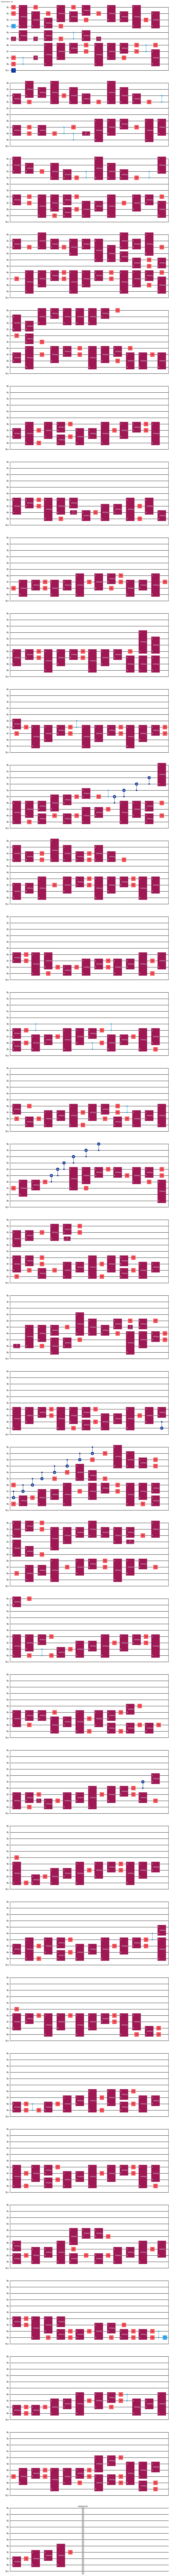

In [ ]:
transpiled_qiskit_3.draw(output='mpl')